In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# LFY031
## Föreläsning 6
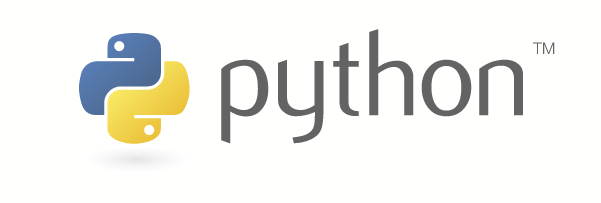
Fredrik Skärberg

#### Dagens agenda

* Frågor? Info
* Fortsättning neurala nätverk
* Introduktion till att skriva "bra" kod och hur man gör tester etc.
* Bildigenkänning med artificiella neurala nätverk.
* -::- med Konvolutional(faltning) neurala nätverk.


* Quiz på mentimeter: 
    * **3515 5482** gå till www.menti.com


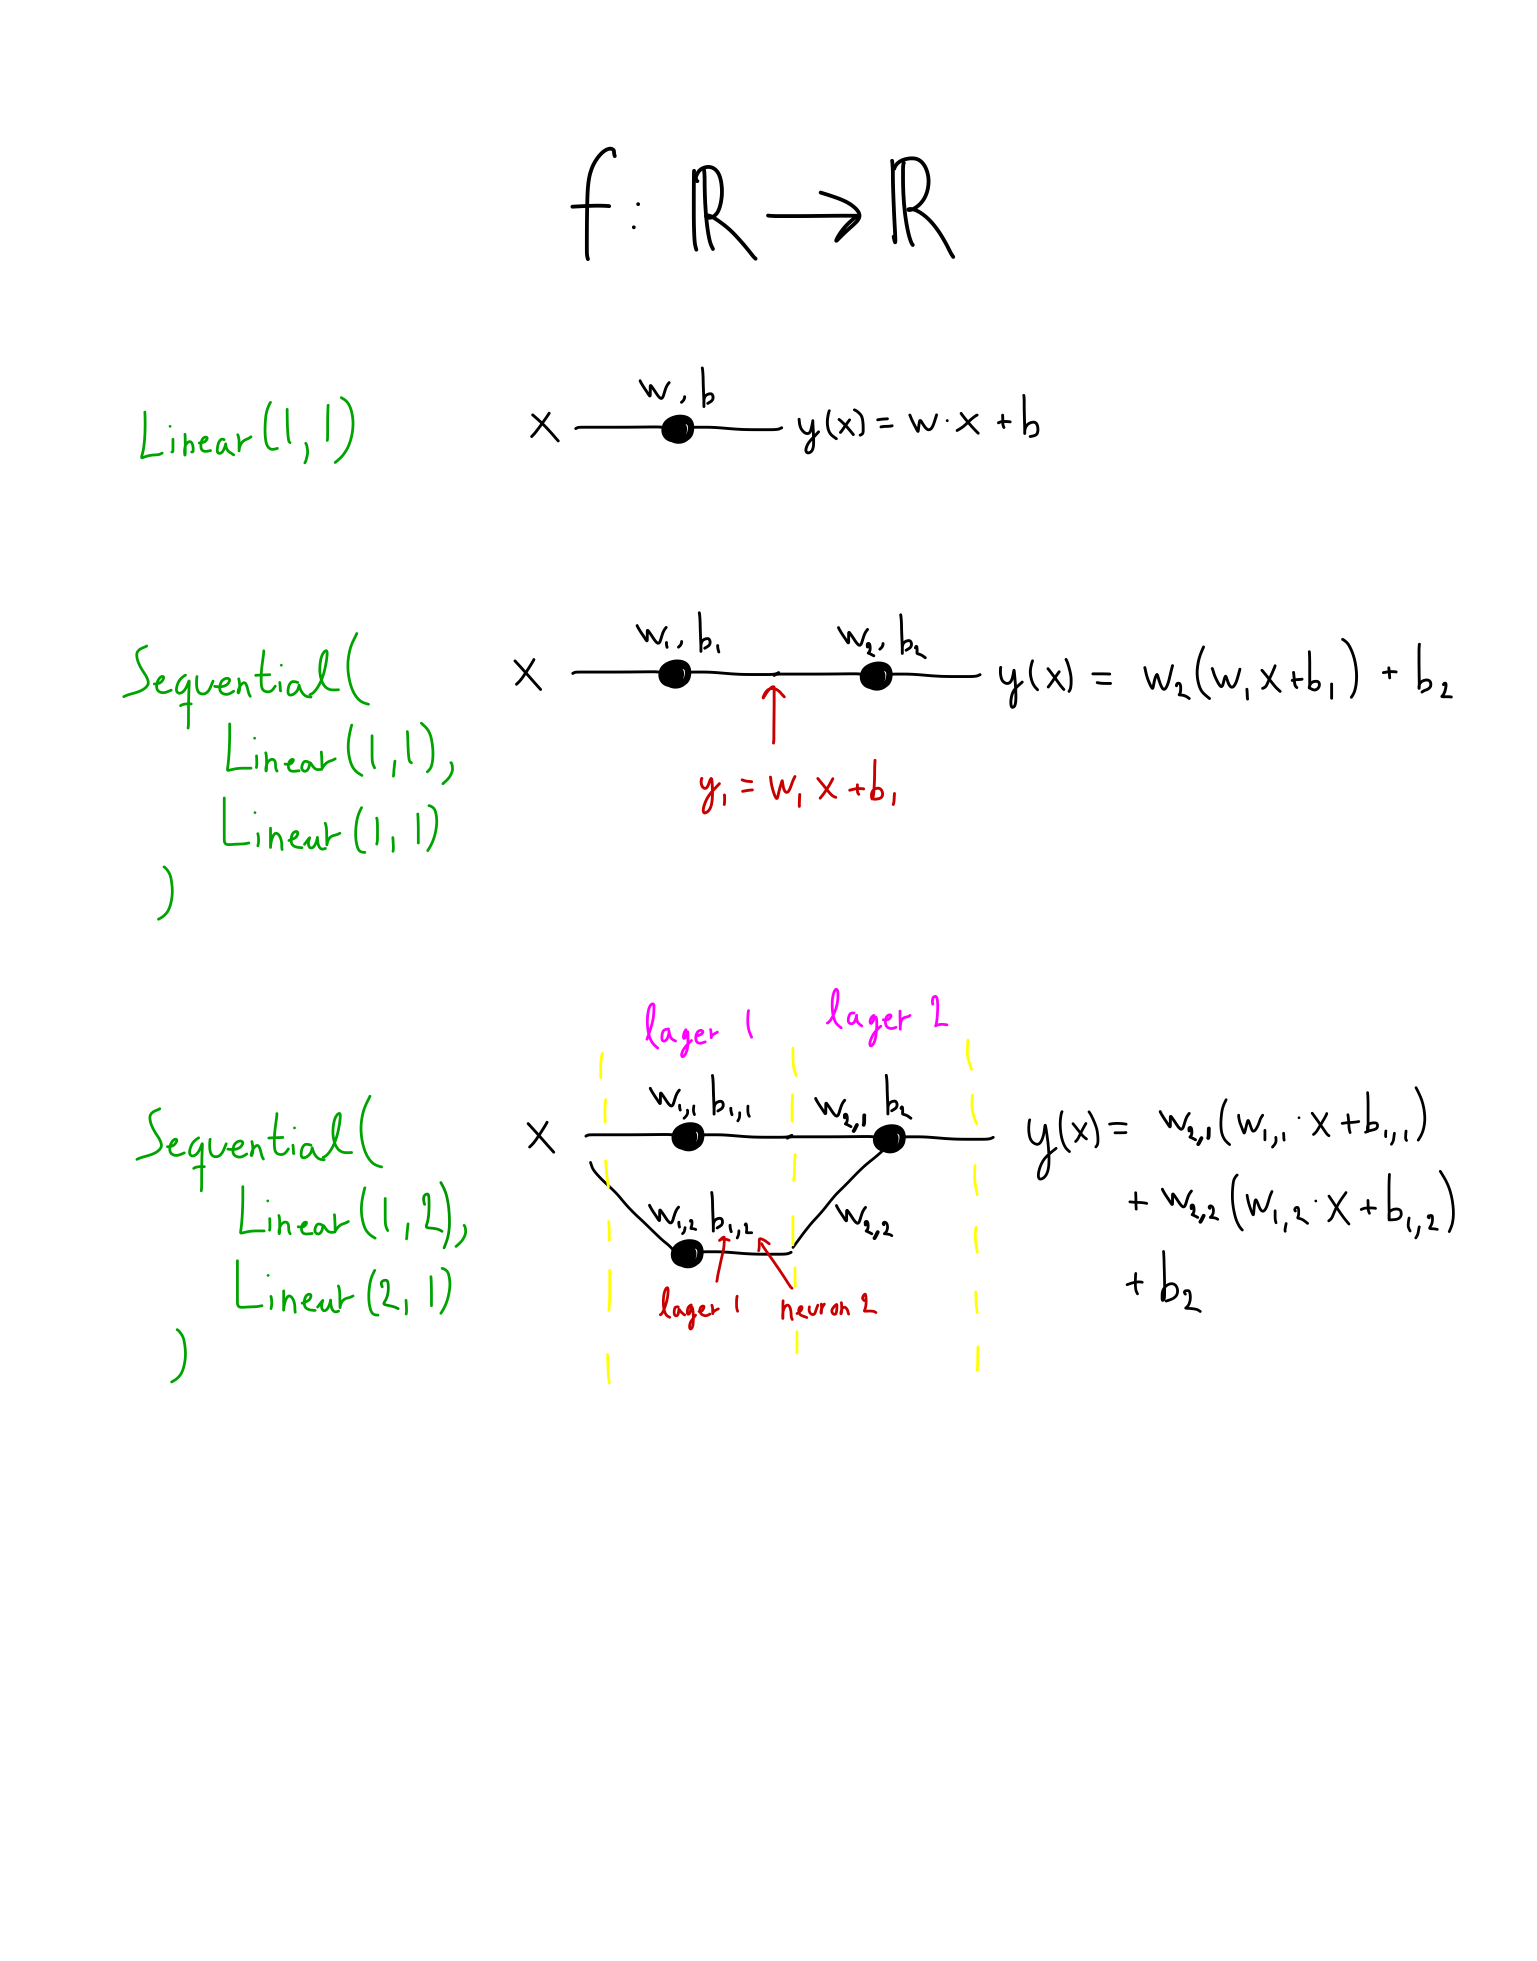

I alla dessa exempel så beskriver hela nätverket tillsammans alltid en linjär funktion, dvs hela nätverket kan beskrivas som $y(x) = w * x + b$. 

För att kunna skapa något icke-linjärt behöver vi introducera aktiveringsfunktioner. En enkel, men även extremt användbar sådan, är 
$$ 
\text{ReLU}(x) = \begin{cases}
x & x > 0 \\
0 & x \leq 0
\end{cases}
$$

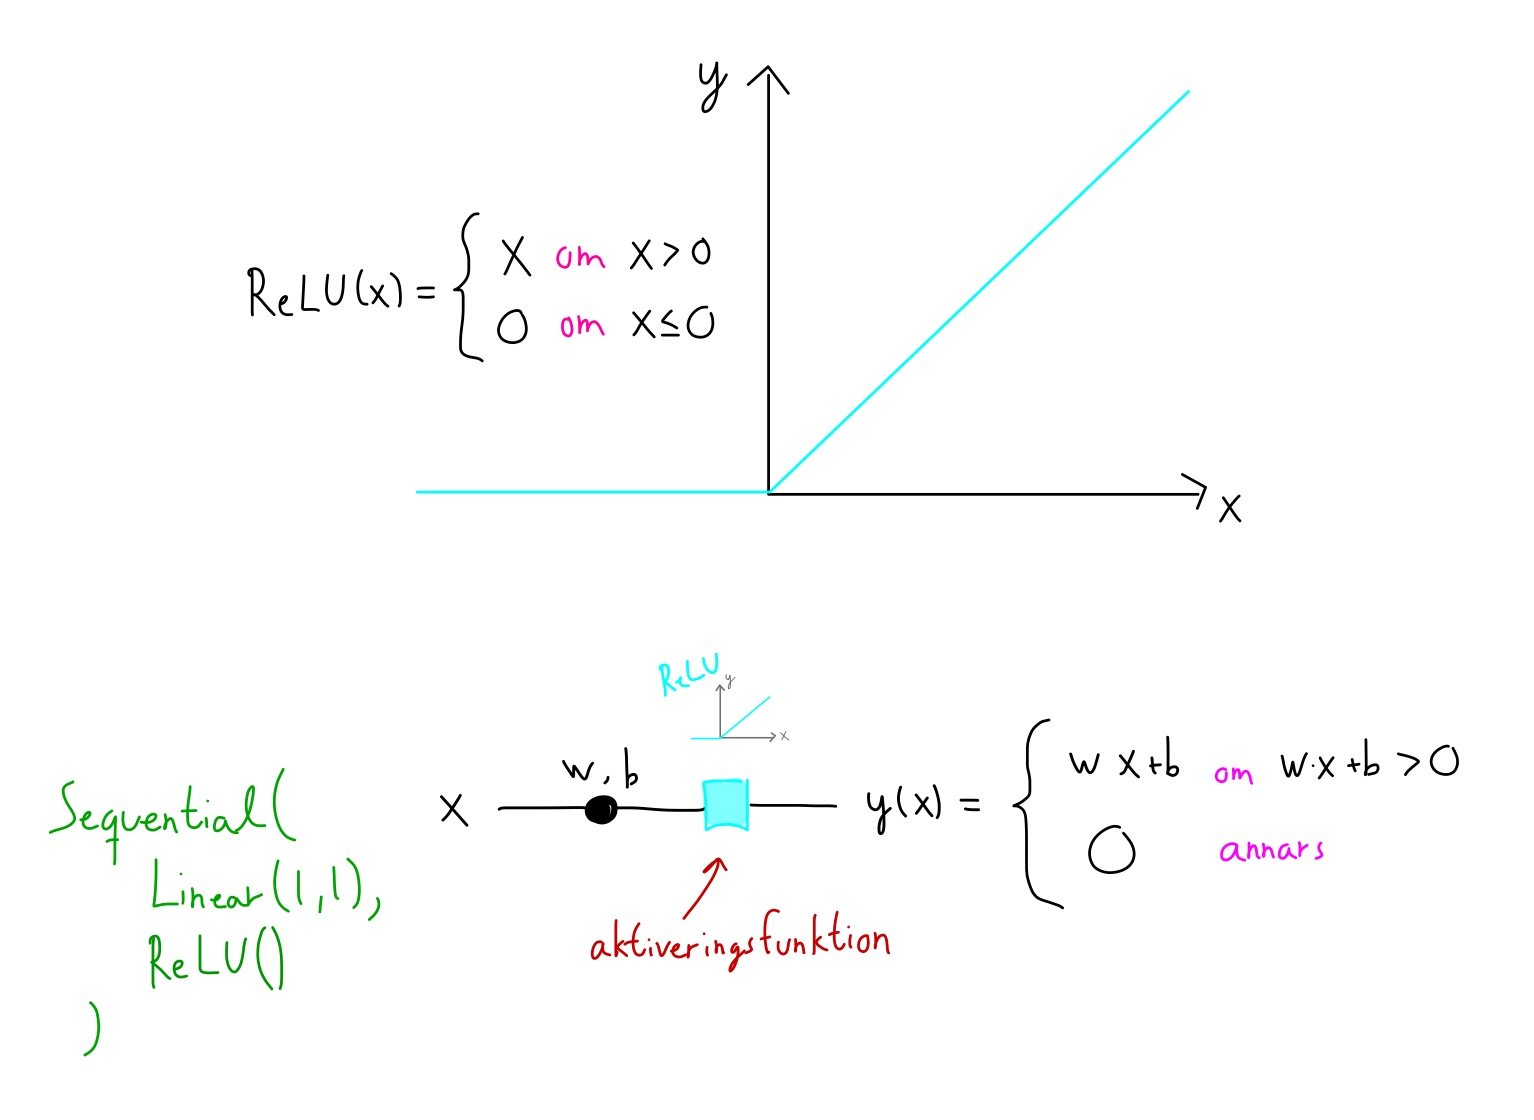

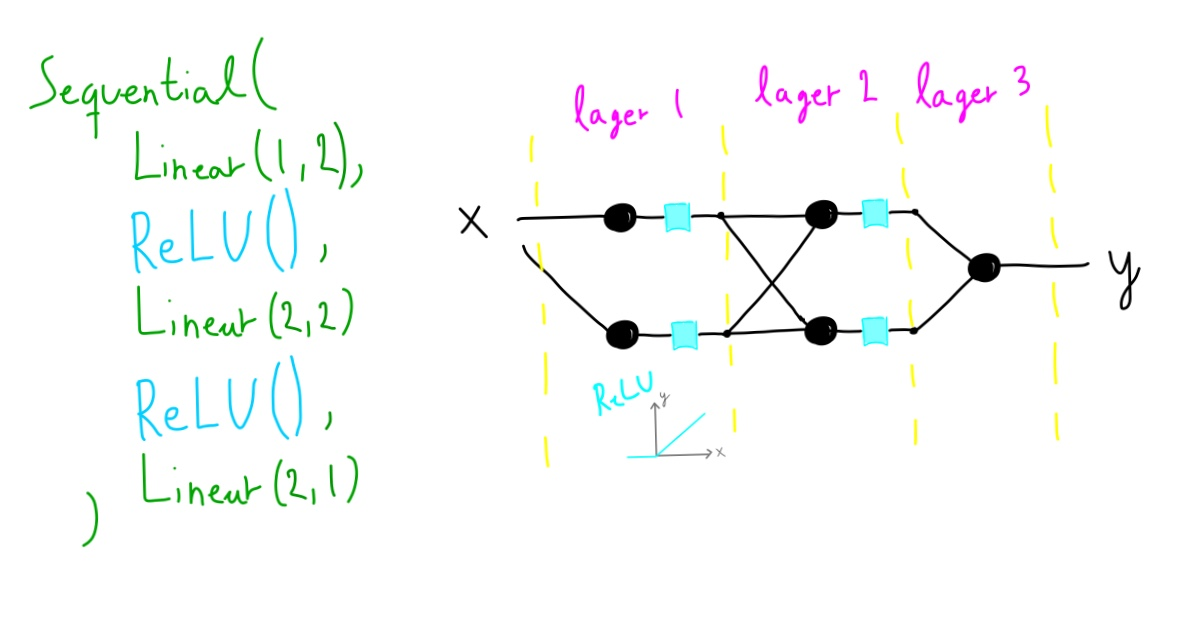

In [2]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,2), 
    torch.nn.ReLU(), 
    torch.nn.Linear(2,2), 
    torch.nn.ReLU(), 
    torch.nn.Linear(2,1)
    )

I neurala nätverk så optimerar vi vikter och biaser i en träningsprocedur. 

Vi kan styra många saker såsom **learning_rate**, **antalet epoker**, **förlustfunktion** och **batch_size**.

Vad som är gemensammt vid träning av neurala nätverk är att det ska ha finnas en förlustfunktion som är deriverbar så vi kan beräkna gradienterna för vår modell.

In [4]:
# Träningsloop - uppdaterar vikterna efter varje träningsexempel.

def träna(xd, yd, model, optimerare, epoker=1000):
    loss_fn = torch.nn.L1Loss()

    for epok in range(epoker):
        totalt_fel = 0.0
        for x, ytarget in zip(xd, yd): 
            x_tensor = torch.tensor([[x]], dtype=torch.float32)  # ensure shape [1,1]
            ytarget_tensor = torch.tensor([[ytarget]], dtype=torch.float32)

            y_pred = model(x_tensor)
            loss = loss_fn(y_pred, ytarget_tensor)

            optimerare.zero_grad()
            loss.backward()
            optimerare.step()

            totalt_fel += loss.item()

        if (epok+1) % 100 == 0:
            print(f'Epok {epok+1}, Totalt fel: {totalt_fel:.4f}')
            
    return totalt_fel

In [5]:
# Träningsloop - uppdaterar vikterna efter varje batch_size träningsexempel.

def träna_batch(xd, yd, model, optimerare, loss_fn=torch.nn.L1Loss(), epoker=1000, batch_size=64, print_error=True):
    n = xd.shape[0]

    for epok in range(epoker):
        
        #Blanda datan - inte ett måste men kan hjälpa
        indices = torch.randperm(n)
        xd_shuffled = xd[indices]
        yd_shuffled = yd[indices]

        totalt_fel = 0.0
        
        # Loopa igenom en batch i taget och uppdatera vikterna
        for i in range(0, n, batch_size):
            xb = xd_shuffled[i:i+batch_size]
            yb = yd_shuffled[i:i+batch_size]

            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)

            optimerare.zero_grad()
            loss.backward()
            optimerare.step()

            totalt_fel += loss.item()

        if (epok+1) % 100 == 0 and print_error:
            print(f'Epok {epok+1}, Loss: {totalt_fel:.4f}')
            
    return totalt_fel


### Exempel - anpassa en funktion

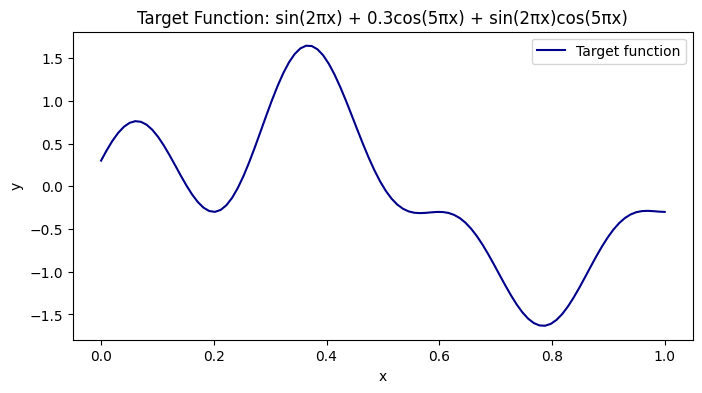

In [7]:
# Generera någon data
np.random.seed(0)
x = np.linspace(0, 1, 100)
y = np.sin(2 * np.pi * x) + 0.3 * np.cos(5 * np.pi * x) + np.sin(2 * np.pi * x)* np.cos(5 * np.pi * x) 

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y, color='darkblue', label='Target function')
plt.title('Target Function: sin(2πx) + 0.3cos(5πx) + sin(2πx)cos(5πx)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [8]:
optimerare = torch.optim.Adam(model.parameters(), lr=0.01)

import time

start_time = time.time()
träna(x_tensor, y_tensor, model, optimerare, epoker=100)
print('Träningstid:', time.time()-start_time)

start_time = time.time()
träna_batch(x_tensor, y_tensor, model, optimerare, epoker=100)
print('Träningstid:', time.time()-start_time)



Epok 100, Totalt fel: 71.5349
Träningstid: 19.759323596954346
Epok 100, Loss: 1.3429
Träningstid: 0.27362561225891113


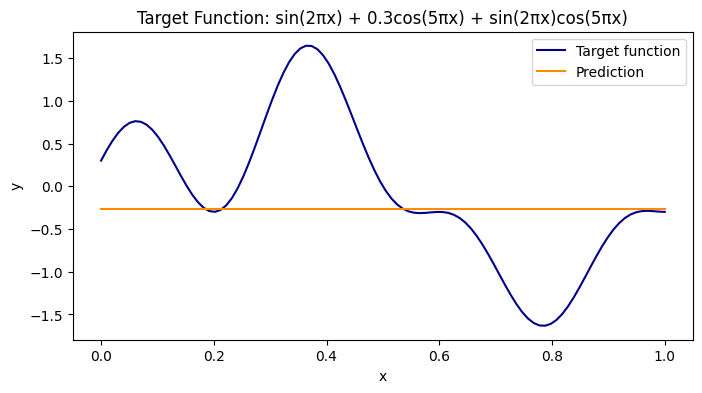

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(x, y, color='darkblue', label='Target function')
plt.plot(x, model(x_tensor).detach().numpy(), label='Prediction', color = 'darkorange')
plt.title('Target Function: sin(2πx) + 0.3cos(5πx) + sin(2πx)cos(5πx)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Vår modell är helt klart för simplistisk för att approximera denna funktionen. Låt oss kolla mer på hur vi kan ändra denna modell

In [10]:
def skapa_modell(input_size, hidden_size, num_hidden_layers, activation_fn, output_size=1, output_activation=None):
    layers = []
    
    # Input-lagret
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(activation_fn)
    
    # Alla gömda lager
    for _ in range(num_hidden_layers - 1):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(activation_fn)
        
    # Output-lagret
    layers.append(nn.Linear(hidden_size, output_size))
    
    if output_activation is not None:
        layers.append(output_activation)
    
    return nn.Sequential(*layers)

In [11]:
model = skapa_modell(1, 5, 2, nn.Tanh())
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 46


Epok 100, Loss: 1.0015
Epok 200, Loss: 0.8498
Epok 300, Loss: 0.7723
Epok 400, Loss: 0.7537
Epok 500, Loss: 0.6979
Träningstid: 2.682002305984497


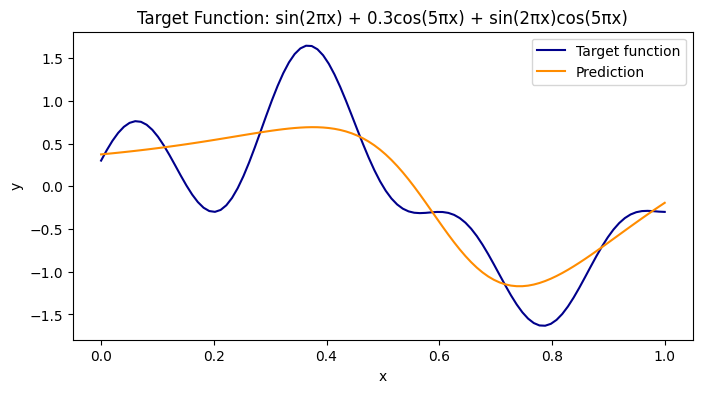

In [13]:
optimerare = torch.optim.Adam(model.parameters(), lr=0.01)

start_time = time.time()
träna_batch(x_tensor, y_tensor, model, optimerare, epoker=500)
print('Träningstid:', time.time()-start_time)

plt.figure(figsize=(8, 4))
plt.plot(x, y, color='darkblue', label='Target function')
plt.plot(x, model(x_tensor).detach().numpy(), label='Prediction', color = 'darkorange')
plt.title('Target Function: sin(2πx) + 0.3cos(5πx) + sin(2πx)cos(5πx)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [14]:
def träna_och_plotta(x_tensor, y_tensor, hidden_size, num_hidden_layers, ax):
    
    model = skapa_modell(1, hidden_size, num_hidden_layers, nn.Tanh())
    optimerare = torch.optim.Adam(model.parameters(), lr=0.01)

    final_loss = träna_batch(x_tensor, y_tensor, model, optimerare, epoker=500, print_error=False)
    print(f'Layers: {num_hidden_layers}, Neurons: {hidden_size}, Final Loss: {final_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(x_tensor).squeeze().numpy()

    ax.plot(x, y, label='True', color='blue')
    ax.plot(x, y_pred, label='NN', color='red', linestyle='--')
    ax.set_title(f'{num_hidden_layers}L, {hidden_size}N\nLoss: {final_loss:.4f}')
    ax.legend()

Layers: 1, Neurons: 5, Final Loss: 1.0298
Layers: 1, Neurons: 10, Final Loss: 0.9370
Layers: 1, Neurons: 20, Final Loss: 0.9799
Layers: 2, Neurons: 5, Final Loss: 0.1481
Layers: 2, Neurons: 10, Final Loss: 0.2629
Layers: 2, Neurons: 20, Final Loss: 0.1237
Layers: 3, Neurons: 5, Final Loss: 0.2401
Layers: 3, Neurons: 10, Final Loss: 0.1109
Layers: 3, Neurons: 20, Final Loss: 0.1138


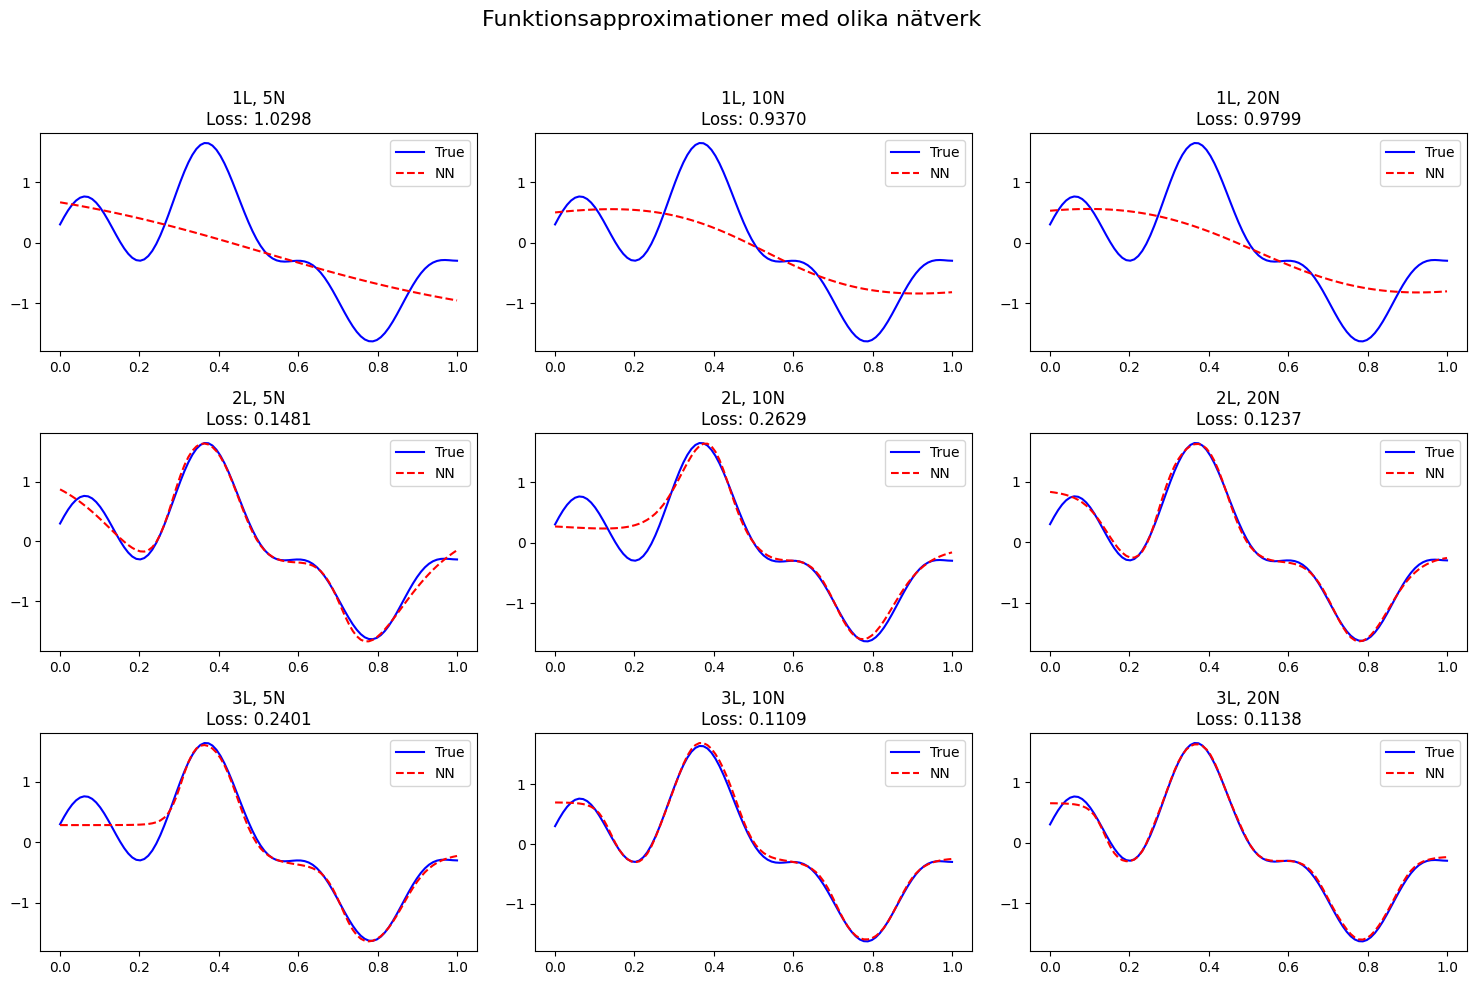

In [15]:
layer_options = [1, 2, 3]
neuron_options = [5, 10, 20]

fig, axes = plt.subplots(len(layer_options), len(neuron_options), figsize=(15, 10))
plt.suptitle('Funktionsapproximationer med olika nätverk', fontsize=16)

for i, num_layers in enumerate(layer_options):
    for j, num_neurons in enumerate(neuron_options):
        träna_och_plotta(x_tensor, y_tensor, num_neurons, num_layers, axes[i, j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

* Mer komplexitet och icke-linjäritet kan införas om vi har fler lager. 
* Att bara öka antalet neuroner ger inte lika mycket.

### Klassificera spiraldata

Klassificera punkterna i två spiraler (klass 0 & 1)


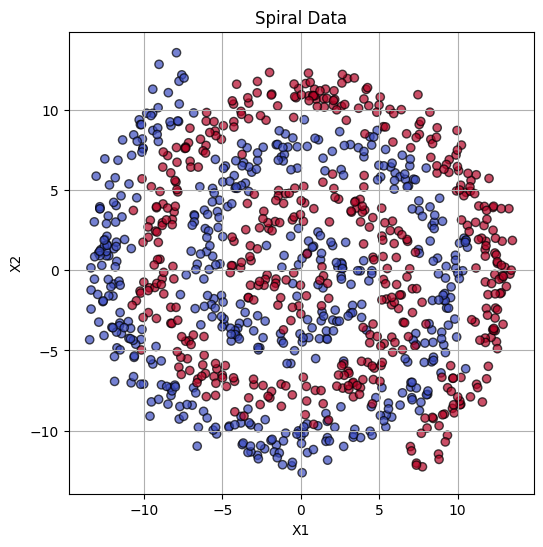

In [42]:
# 1. Generera spiraldata
def generate_spiral(n_points, noise=0.1):
    n = np.sqrt(np.random.rand(n_points)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points)*noise
    d1y = np.sin(n)*n + np.random.rand(n_points)*noise
    X = np.vstack((np.append(d1x, -d1x), np.append(d1y, -d1y))).T
    Y = np.hstack((np.zeros(n_points), np.ones(n_points)))
    return X, Y

X, Y = generate_spiral(500)
X += np.random.normal(0, 0.85, X.shape) #Korrigera för brus

# 2. Visualisera spiraldata
def plot_spiral_data(X, Y):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', edgecolor='k', alpha=0.7)
    plt.title('Spiral Data')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.show()

plot_spiral_data(X, Y)

In [43]:
# Nätverk
model = skapa_modell(
    input_size=2, 
    hidden_size=16, 
    num_hidden_layers=2, 
    activation_fn=nn.ReLU(), 
    output_activation=nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)


Vi använder sigmoid för aktiveringsfunktion för att vi vill prediktera klasser. Antingen klass 0 eller klass 1.

In [44]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 337


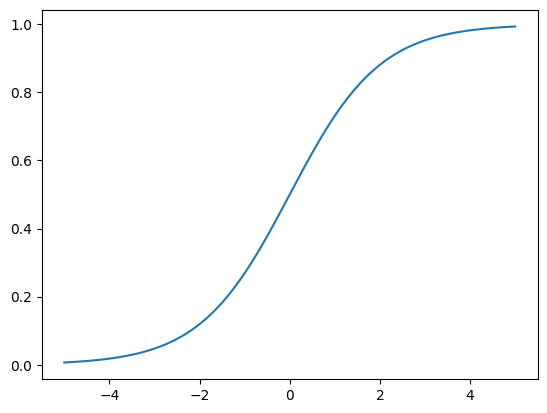

In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Skapa x-värden
x_vals = np.linspace(-5, 5, 200)
y_vals = sigmoid(x_vals)
plt.plot(x_vals, y_vals)

In [46]:
x_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(Y.reshape(-1,1), dtype=torch.float32)

In [47]:
optimerare = torch.optim.Adam(model.parameters(), lr=0.01)
träna_batch(x_tensor, y_tensor, model, optimerare, loss_fn=torch.nn.BCELoss(), epoker=1000, batch_size=64)

Epok 100, Loss: 2.7278
Epok 200, Loss: 1.7461
Epok 300, Loss: 2.2675
Epok 400, Loss: 1.5777
Epok 500, Loss: 1.9018
Epok 600, Loss: 1.7856
Epok 700, Loss: 1.7449
Epok 800, Loss: 1.4962
Epok 900, Loss: 1.4307
Epok 1000, Loss: 1.2963


1.2962968312203884

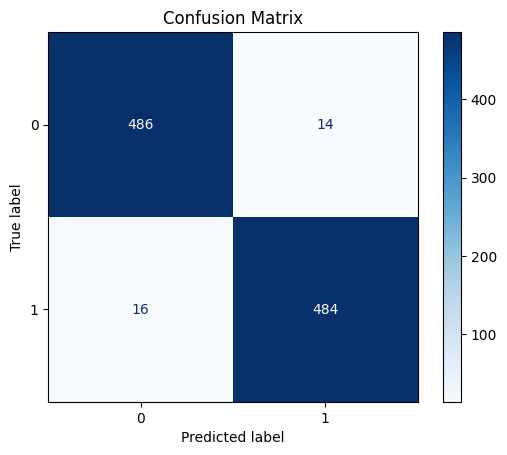

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Prediktera alla datapunkter
with torch.no_grad():
    y_pred_tensor = model(x_tensor)
    y_pred_classes = (y_pred_tensor >= 0.5).int().numpy().flatten()

# 2. Sanna klasser
y_true_classes = y_tensor.numpy().flatten().astype(int)

# 3. Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Visualisera
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

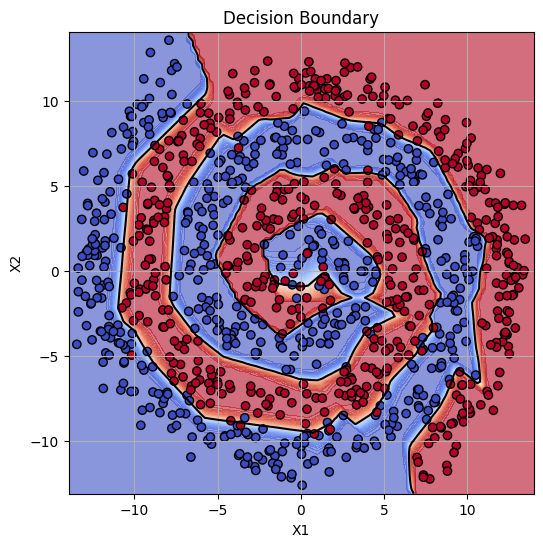

In [49]:
def plot_decision_boundary(model, X, Y, steps=100):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    with torch.no_grad():
        preds = model(grid_tensor).numpy().reshape(xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, preds, levels=50, cmap='coolwarm', alpha=0.6)
    plt.contour(xx, yy, preds, levels=[0.5], colors='black')
    plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', edgecolor='k')
    plt.title('Decision Boundary')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.show()

# Gör figuren    
plot_decision_boundary(model, X, Y)

# Vad är bra och vad är dålig kod?


### BRA KOD ###

In [51]:
def calculate_distance(x1, y1, x2, y2):
    """Beräkna euklidiska distansen mellan två punkter"""
    delta_x = x2 - x1
    delta_y = y2 - y1
    distance = (delta_x ** 2 + delta_y ** 2) ** 0.5
    return distance

# Indata - två punkter
point1 = (10, 20)
point2 = (15, 25)

#Beräkna distansen mellan två punkter
distance = calculate_distance(*point1, *point2)
print(f"Avståndet mellan punkt {point1} och {point2} är: {distance}")

Avståndet mellan punkt (10, 20) och (15, 25) är: 7.0710678118654755


### "DÅLIG" KOD ###

In [52]:
a = 10  # Variabel 1
b = 20  # Variabel 2
c = 15  # Variabel 3
d = 25  # Variabel 4

#Räkna ut resultatet
res = ((c - a) ** 2 + (d - b) ** 2) ** 0.5

# Visa resultatet
print("D: " + str(res))


D: 7.0710678118654755


* "Dålig" kod är väldigt vanligt förekommande.
* "Skadan" av dålig kod kanske inte sker direkt.

<img src="../images/bra_vs_dålig_kod.png" width=60%/>

* Vad behöver man göra för att få kod att se mer proffsig ut? 

# PEP
[PEP (Python Enhancement Proposal)](https://www.python.org/dev/peps/) är formaliserade dokument som beskriver olika aspekter av Python och dess ekosystem.

## PEP 1 - PEP Purpose and Guidelines

> The PEP should provide a concise technical specification of the feature and a rationale for the feature.

## PEP 8, PEP 257

Mycket av principerna från dagens föreläsning kommer från de kodkonventioner som finns för Python. 

Detta är standarder som specifierar rekommendationer för hur kod och kommentarer skall se ut.

* [PEP 8 - Style Guide for Python Code](https://www.python.org/dev/peps/pep-0008/)
* [PEP 257 - Docstring Conventions](https://www.python.org/dev/peps/pep-0257/)

## PEP 20 – The Zen of Python

* [PEP 20 – The Zen of Python](https://peps.python.org/pep-0020/)

In [53]:
#Ett "Easter-Egg" i Python
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Låt oss gå igenom några koncept som gäller vi skrivning av BRA kod

# 1. Indentering

 * 4 mellanslag är det som rekommenderas i Python.
 * Var konsekvent och indentera alltid med lika många mellanslag i hela koden.

In [56]:
# Korrekt (enligt Style Guide för Python Code)
max_tal = 5
if max_tal > 4:
    print(f'Max antal är {max_tal}')

# Felaktigt (enligt Style Guide för Python Code)
if max_tal > 4:
    print(f'Max antal är {max_tal}')

Max antal är 5
Max antal är 5


# 2. Namn

## Variabler, funktioner och klasser
För att öka läsbarhet i kod så är valet av namn viktigt.


## Exempel
```python
data = open("namn_och_ålder.txt").readlines()

for x in data:
    y, z = x.split(",")
    print(f"Namn: {y}, Ålder: {z}")
```

## Exempel - läsbara namn
```python
lines = open("namn_och_ålder.txt").readlines()

for line in lines:
    name, age = line.split(",")
    print(f"Namn: {name}, Ålder: {age}")
```

# Några principer
* Beskrivande namn: Det skall gå att förstå vad som lagras i en variabel eller vad en funktion gör från namnet
* "snake case" i Python, dvs. Flera ord separeras med `_`
* Gemener

Exempel
```python
antal_bokstaver = len("nationalencyklopedin")
```

## Undantag
Namn på globala konstanter brukar skrivas med versaler.

```python
PI = 3.14159265

def area_cirkel(radie):
    return PI * radie**2

```

## Namn på klasser

I Python används vanligtvis "Kamel"-stil (camel case) för klasser, dvs ord börjar med stor bokstav och utan avskiljare till nästa ord.

```python
class MinKlass:
    pass

class Persons:
    pass

```

## Namn på funktioner

Följer samma regler som variabler, dvs gemener men ord sammanbundna av `_`.

```python
def count_people():
    pass

def add_elements():
    pass

```

# 3. Funktioner

Funktioner gör det möjligt att dela upp kod i mindre delar. För att använda detta effektivt är det bra att tänka på följande tips

* Varje funktion ska göra bara en sak
* Eventuella data/parametrar som funktionen behöver skall ges som argument
    * Utdata skall vara en funktion av endast indata
    * Minimera beroendet på globala variabler
* Minimera påverkan av globala variabler
* De bör vara ungefär 5 - 15 rader långa (om det går...).
* Undvik print-satser i funktioner

In [57]:
data = """
A 1
B 2
C 434
D 5
"""

def find_best_letter():
    lines = data.strip().split("\n")
    letter_score_list = []
    for line in lines:
        letter, number_str = line.split(" ")
        number = int(number_str)
        letter_score_list.append((letter, number))
    sorted_letter_scores = sorted(letter_score_list, key=lambda letter_and_score: letter_and_score[1])
    return sorted_letter_scores[-1]

In [59]:
find_best_letter()

('C', 434)

In [60]:
def load_lines(data):
    return data.strip().split("\n")

def parse_one_line(line):
    letter, number_str = line.split(" ")
    return letter, int(number_str)

def get_score(letter_and_score):
    letter, score = letter_and_score
    return score

def find_best_letter(data):
    lines = load_lines(data)
    letter_and_score_list = []
    for line in lines:
        letter_and_score = parse_one_line(line)
        letter_and_score_list.append(letter_and_score)
    sorted_letter_scores = sorted(letter_and_score_list, key=get_score)
    return sorted_letter_scores[-1]

# 4 Kommatecken, mellanslag och parenteser

* Som princip bör man använda ett och endast ett mellanslag vid tilldelning både före och efter tilldelningstecknet.
* Undvik extra mellanslag vid funktions- och metod-anrop.
* Inga parenteser i if- och while-satser.
* Med mera...

[PEP 8 - whitespace in expressions and statements](https://peps.python.org/pep-0008/#whitespace-in-expressions-and-statements)


In [62]:
###KORREKT###
max_count = 10

###FEL###
max_count=10
max_count =10
max_count= 10

In [63]:
###KORREKT###
x = 1
y = 2
long_variable = 3

###FEL###
x             = 1
y             = 2
long_variable = 3

In [64]:
###KORREKT###
if x == 10:
    pass

###FEL###
if x==10:
    pass
    
if x ==10:
    pass
    
if x== 10:
    pass

In [68]:
###KORREKT###
def calculate(a, b, c):
    pass

###FEL###
def calculate(a,b,c):
    pass

def calculate( a,b,c ):
    pass

def calculate(a,b, c):
    pass

In [67]:
###KORREKT###
x=100
if x == 10:
    pass
    
while x < 10 and y <= 10:
    pass

###FEL###
if (x == 10):
    pass
    
if(x == 10):
    pass
    
while(x < 10 and y <= 10):
    pass    

while (x < 10 and y <= 10):
    pass

# 5. Moduler

På samma sätt som en funktion bara bör göra en sak så bör en modul ha ett tydligt syfte. Eftersom en Python-modul motsvarar en fil med Python-kod så betyder det att i ett större program så bör varje `.py` fil innehålla funktioner som hör tillsammans.

In [69]:
#Exempelmodul: arithmetic_operations.py
def add(x, y):
    """Return the sum of two numbers."""
    return x + y

def subtract(x, y):
    """Return the difference between two numbers."""
    return x - y

def multiply(x, y):
    """Return the product of two numbers."""
    return x * y

def divide(x, y):
    """Return the result of dividing x by y."""
    if y != 0:
        return x / y
    else:
        raise ValueError("Cannot divide by zero.")

```python
import arithmetic_operations

result_add = arithmetic_operations.add(5, 3)
result_subtract = arithmetic_operations.subtract(8, 2)
result_multiply = arithmetic_operations.multiply(4, 6)
```

# 6. Kommenterad kod

Ett bra mål är att skriva kod som förklarar sig själv, t.ex genom att använda de principer vi tittat på hitils idag.

Ofta uppkommer sittuationer där det trots detta finns utrymme för att förtydliga vad som händer genom att använda kommentarer.

* Kommentarer som strider mot koden är värre än inga kommentarer.
* Prioritera alltid att hålla kommentarerna uppdaterade när koden ändras!
* Kommentarer ska vara fullständiga meningar.

```python
### KORREKT ###

# Calculate from Fahrenheit to Celsius
temperature_celsius = 5/9 * (temperature_fahrenheit-32)


### FEL ###

temperature_celsius = 5/9 * (temperature_fahrenheit-32)
# Calculate from Fahrenheit to Celsius
```

# Kommentera funktioner

Det finns olika standarder för hur en funktion bör dokumenteras med hjälp av kommentarer men gemensamt är att en funktion bör ha en textsträng som första rad beskriver vad funktionen gör.

```python
def funk():
    """Gör något användbart."""
```

Vidare kan texten innehålla information om funktionens argument samt dess returvärden.

Denna typ av sträng i börjar av funktioner kallas **docstring**. Namnet kommer av att det finns moduler som använder sig av denna informationen för att automatiskt skapa dokumentation för ett program.


In [70]:
# Googles Python stil.
def load_lines(filename):
    """Load lines from file.
    
    Strips extra whitespaces.
    
    Args:
        filename (str): Path to input file
        
    Returns:
        list(str): List of lines
        
    """

In [71]:
# rST stil
def load_lines(filename):
    """Load lines from file.
    
    Strips extra whitespaces.
    
    :param filename: path to input file
    :type filename: str
    :returns: List of lines
    :rtype: list(str)
    
    """

# 7. F-strängar
* Använd alltid f-strängar vid formatering/utskrift av värden. 
* Det finns 3 sätt att formatera strängar, men f-strängar är snabbast och ger den bästa läsbarheten.

In [73]:
### KORREKT ### - f-strings introduced in Python 3.6
name = "Ragnar"
age = 74

print(f"Hello, {name}. You are {age}.")

### FEL ###
name = "Ragnar"
age = 74

# Old school original formatting
print("Hello, %s. You are %s." % (name, age))

# Old, introduced in Python 2.6
print("Hello, {}. You are {}.".format(name, age))

Hello, Ragnar. You are 74.
Hello, Ragnar. You are 74.
Hello, Ragnar. You are 74.


# Sammanfattning
* Håll en enhetlig kodstil genom att använda samma konventioner överallt.
* Använd 4 mellanslag för indentering.
* Använd beskrivande namn och snake_case för variabler och funktioner.
* Sätt mellanslag mellan operatorer för ökad läsbarhet.
* Undvik mellanslag direkt före kolon.
* Undvik extra mellanslag vid funktions- och metodanrop.
* Undvik mellanslag direkt inom parenteser (), hakparenteser [].
* Undvik onödiga parenteser i if- och while-satser.
* Omge funktionsdefinitioner med 2 tomma rader.
* Använd tomma rader sparsamt för att markera logiska avsnitt i koden.
* Välj antingen enkla eller dubbla citattecken för att markera strängar och håll dig konsekvent.
* Använd alltid f-strängar för formatering och utskrift av värden.
* Undvik flera satser på samma rad i allmänhet.
* Undvik användning av globala variabler inuti funktioner.
* Kommentera din kod för att förklara dess syfte och funktionalitet.
* Skriv docstrings för alla publika moduler och funktioner för att dokumentera deras användning och parametrar.


# Automatiska verktyg för formattering av kod

## Linting
Verktyg för att ge varningar när kod inte uppfyller konventioner.

* [pylint](https://pypi.org/project/pylint/)
* [flake8](https://flake8.pycqa.org/en/latest/)
* [pycodestyle](https://pycodestyle.pycqa.org/en/latest/)

## Formatterare
Formaterar om kod för att uppfylla konventioner.

* [autopep8](https://github.com/hhatto/autopep8)
* [black](https://black.readthedocs.io/en/stable/)

Många IDEs som t.ex pycharm och visual studio code har stöd för dessa verktyg och integrerar dem för enkel användning.

# Testning

<img src="../images/systemutvecklingsprocessen.png" width=75%/>

* När ett program är uppbyggt av välavgränsade modulära delar, t.ex med funktioner med de principer vi gått igenom, så finns möjligheten att testa dessa delar i isolering.

* När vi vet vilken typ av indata och utdata som är relevant för en funktion så går det ofta att enkelt skapa ett test som verifierar att funktionen är korrekt implementerad.

* Denna typ av tester kallas ofta **enhetstester** (unit test).

## Exempel - enhetstest
Manuell enhetstestning

In [74]:

def sum_list(input_list):
    output = 0
    for element in input_list:
        output += element
    return output

def test_sum_list():
    test_list = [-2, 5, 9]
    expected_sum = -2 + 5 + 9
    return sum_list(test_list) == expected_sum

test_sum_list()

True

## Fördelar med enhetstester

* Det är ofta enklare att testa små delar än hela programmet för alla möjliga beteenden
* När ett fel hittas är det isolerat till en liten bit kod vilket ofta gör det enkelt att korrigera
* Om en funktion behöver skrivas om eller uppdateras så ger enhetstester ett systematiskt sätt att kontrollera att beteendet för en bit kod inte har ändrats.


## Hjälpmedel för enhetstestning i Python

I många språk finns det moduler och verktyg för att underlätta testning. Python har ett antal moduler för detta syfte varav de två mest använda är
* [unittest](https://docs.python.org/3/library/unittest.html) - Inbygd modul med fokus på enhetstestning
* [pytest](https://docs.pytest.org/) - "The pytest framework makes it easy to write small tests, yet scales to support complex functional testing for applications and libraries."

Då `pytest` har en enklare syntax och är mer flexibel så rekommenderas det ofta idag.

## PyTest

### Skriva tester
Ett test i pytest är helt enkelt en funktion vars namn börjar på `test_` och som finns i en Python-fil vars namn böjar (eller slutar) på `test`.

`test_funktion.py`
> ```python
> def test_av_funktion():
>   assert True
> ```
### Köra tester
Från en terminal körs
> ```shell
> pytest
>
vilket letar efter alla filer som börjar på `test_` och alla funktioner i dessa filer som börjar på `test_` och kör dem en efter en.

# Bildigenkänning med klassificering

## MNIST
![MNIST2](../images/mnist.png)

<img src="../images/mnist_2digits.png"/>

### Dataformat
* $ 28 \times 28$ pixlar
* Gråskala, värden mellan 0 och 1

In [75]:
import torchvision
import torch
import matplotlib.pyplot as plt

### Läsa in data via torchvision

In [76]:
mnist = torchvision.datasets.MNIST('../datasets', train=True, download=True, transform=torchvision.transforms.ToTensor())

In [78]:
print(len(mnist))

60000


In [79]:
mnist.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Printa fördelningen av siffror

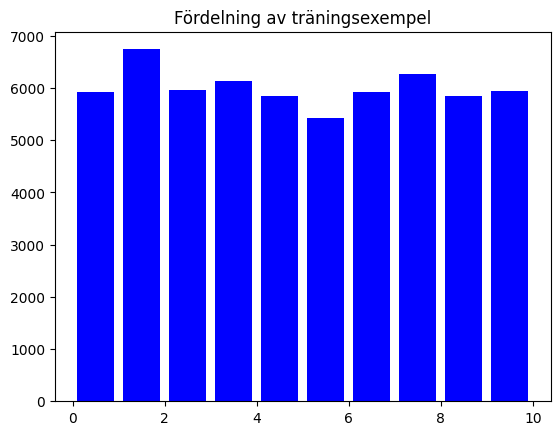

In [80]:
siffror = []
for i in range(len(mnist)):
    siffror.append(mnist[i][1])
plt.hist(siffror, bins=10, range=(0, 10), align='mid', rwidth=0.8, color='blue', label='Siffror')
plt.title('Fördelning av träningsexempel')
plt.show()

In [81]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size=128)
examples = iter(train_loader)

In [82]:
bilder, siffror = next(examples)
print(bilder.shape)
print(siffror.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


tensor(0.)
tensor(0.)
tensor(0.)


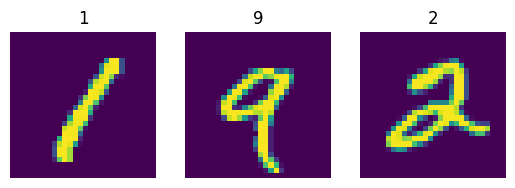

In [83]:
# Visa några exempel

# zip(bilder[:3], siffror[:3]) skapar en lista av tupler [(bild1, siffra1), (bild2, siffra2), ...]
for n, (bild, siffra) in enumerate(zip(bilder[3:6], siffror[3:6])):
    plt.subplot(1, 3, n + 1)
    plt.imshow(bild[0])
    plt.axis("off")
    plt.title(siffra.item())
    print(bild[0,0,0])

# Neuralt nät för bildklassificering

<img src="../images/mnistmodel_small.png" width=50%/>

Sista lagret i nätverket innehåller 10 neuroner som alla resulterar i ett flyttal. Vi har alltså en vektor med längden 10 som utdata från modellen, t.ex $[0, 0.8, 0, 0, 0, 0, 0, 0.2, 0, 0]$.

$$
\left[ 0.0, \underbrace{0.8}_{\text{sannolikhet för siffran 1}}, 0, 0, 0, 0, 0, \underbrace{0.2}_{\text{sannolikhet för siffran 7}}, 0, 0\right]
$$

In [84]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.LogSoftmax(dim=1) # Tvinga talen i sista lagret att ha värden mellan 0.0 och 1.0
)

### Softmax
För att kunna göra en sannolikhetstolkning av prediktionen från det neurala nätet så tvingar vi talen i sista lagret att bilda en distribution, dvs att alla tal är mellan 0 och 1 samt att summan av alla tal är 1.

Dvs. Softmax är en aktiveringsfunktion för att omvandla en vektor av råa, icke-normaliserade tal (ofta kallade logits eller scores) till en sannolikhetsdistribution.


Matematiskt uttryckt, om $\mathbf{z}$ är en vektor av råa värden och $\sigma(\mathbf{z})$ är resultatet av softmax-funktionen:

$$ \sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$



In [87]:
t = torch.Tensor([1, 2, 3, 4, 5])
p = torch.nn.functional.softmax(t, dim=0)
print(p)

tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])


In [88]:
p.sum()

tensor(1.)

In [90]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.LogSoftmax(dim=1) # Tvinga talen i sista lagret att ha värden mellan 0.0 och 1.0
)

optimerare = torch.optim.Adam(model.parameters(), lr=0.01)

In [91]:
# Träna det neurala nätet genom att gå igenom all data
def train(omgång, model, train_loader, optimerare):
    for batch_idx, (image, digit) in enumerate(train_loader):
            output = model(image)
            loss = torch.nn.functional.nll_loss(output, digit)
            # 4 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
            optimerare.zero_grad()
            loss.backward()
            optimerare.step()
            if batch_idx % 100 == 0: # Visa information då och då
                print('Träningsomgång: {} [{}/{} ({:.0f}%)]\t Fel: {:.6f}'.format(
                    omgång, batch_idx * len(image), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

`torch.nn.functional.nll_loss` står för "Negative Log Likelihood Loss," och det används främst för klassificeringsuppgifter när du har logaritmer av sannolikheterna som modellens utdata. Här är en förklaring av funktionen:

Matematiskt kan det uttryckas som:

$$
\text{NLLLoss}(\mathbf{y}, \mathbf{t}) = -\frac{1}{N} \sum_{i=1}^{N} \log(y_{i, t_i})
$$

där:
- $\mathbf{y}$ är logaritmen av sannolikheterna för varje klass (modellens utdata).
- $\mathbf{t}$ är vektorn av sanna klassetiketter för varje instans i batchen.
- $N$ är antalet instanser i batchen.

Dvs. desto närmare vi är 1 för korrekt klass, desto mindre loss kommer vi att ha.

In [92]:
for i in range(4):
    train(i, model, train_loader, optimerare)

Träningsomgång: 0 [0/60000 (0%)]	 Fel: 2.305462
Träningsomgång: 0 [12800/60000 (21%)]	 Fel: 0.282181
Träningsomgång: 0 [25600/60000 (43%)]	 Fel: 0.196935
Träningsomgång: 0 [38400/60000 (64%)]	 Fel: 0.157085
Träningsomgång: 0 [51200/60000 (85%)]	 Fel: 0.253239
Träningsomgång: 1 [0/60000 (0%)]	 Fel: 0.106197
Träningsomgång: 1 [12800/60000 (21%)]	 Fel: 0.127813
Träningsomgång: 1 [25600/60000 (43%)]	 Fel: 0.112039
Träningsomgång: 1 [38400/60000 (64%)]	 Fel: 0.089668
Träningsomgång: 1 [51200/60000 (85%)]	 Fel: 0.178945
Träningsomgång: 2 [0/60000 (0%)]	 Fel: 0.167258
Träningsomgång: 2 [12800/60000 (21%)]	 Fel: 0.195842
Träningsomgång: 2 [25600/60000 (43%)]	 Fel: 0.172544
Träningsomgång: 2 [38400/60000 (64%)]	 Fel: 0.095282
Träningsomgång: 2 [51200/60000 (85%)]	 Fel: 0.183783
Träningsomgång: 3 [0/60000 (0%)]	 Fel: 0.099988
Träningsomgång: 3 [12800/60000 (21%)]	 Fel: 0.089173
Träningsomgång: 3 [25600/60000 (43%)]	 Fel: 0.180892
Träningsomgång: 3 [38400/60000 (64%)]	 Fel: 0.101519
Träningsomgån

### Ladda in testdata och prediktera på. Viktigt att evaluera modell på data den inte är tränad på!

In [93]:
mnist_test = torchvision.datasets.MNIST('./datasets', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1)
examples = iter(test_loader)

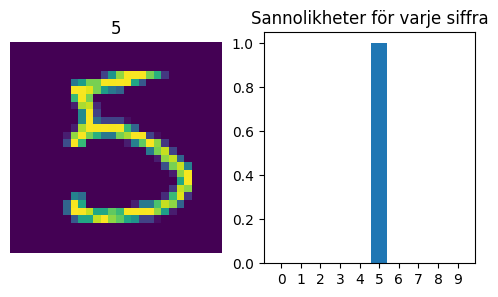

Rätt siffra: 5 Prediktion: 5 


In [116]:
for _ in range(1):
    bild, siffra = next(examples)
    ut = model(bild)
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title(ut.argmax(dim=1).item())
    plt.imshow(bild[0][0])
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Sannolikheter för varje siffra")
    plt.bar(range(10), torch.exp(ut[0]).detach().numpy())
    plt.xticks(range(10))
    plt.show()
    print(f"Rätt siffra: {siffra.item()} Prediktion: {ut.argmax(dim=1).item()} ")


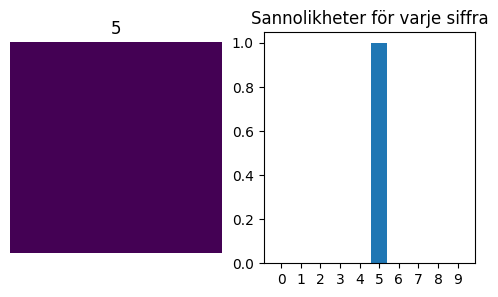

In [113]:
#bild = torch.rand(1, 1, 28, 28) #slumpmässiga tal mellan 0-1.
#bild = torch.zeros(1, 1, 28, 28) # Bara nollor.
#bild = torch.ones(1, 1, 28, 28) # Bara ettor.

#siffra = torch.tensor([1])

ut = model(bild)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title(ut.argmax(dim=1).item())
plt.imshow(bild[0][0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Sannolikheter för varje siffra")
plt.bar(range(10), torch.exp(ut[0]).detach().numpy())
plt.xticks(range(10))
plt.show()

### Man får alltid en prediktion. Och nätverket är ofta "säker" på sitt svar även om inputen är "ingenting".

Okej det funkar ju bra att platta till en bild till en vektor och mata in till ett artificiellt neuralt nätverk. 

Men kanske måste man inte platta till en bild? Vi förlorar ju en del spatial information på detta sättet. Och såhär ser väl inte vår hjärna på en bild?

# Konvolutional(faltning) neurala nätverk

* Förmodligen den mest frekvent använda formen av ett neuralt nätverk är ett CNN. Dessa nätverk opererar på matriser/vektorer (vilken storlek som helst, men framförallt på bilder...). Vilket gör att de har stora tilläpmningsområden.

* Kan ses som modeller som extraherar mönster från bilder -> och sen kopplar samman med ett ANN.

* ANN är fortfarande väldigt kraftfulla, men CNN;s har endel fördelar.

### Varför Konvolutional neurala nätverk?

#### Vad är det här en bild på?
<img src="../images/dog_flatten.png" width=50%/>

<img src="../images/dog_normal.png" width=50%/>

#### Båda är av samma bild. Har samma pixelvärden. Ena är en 1D representation och den andra en 2D representation!


#### Artificiella neurala nätverk förlorar spatiell orientering. Ser du någon skillnad mellan dessa bilder?
<img src="../images/dog_flatten_rot.png" width=50%/>

<img src="../images/dog_rot.png" width=50%/>

#### Vi ändrade bara postionen av ett par pixlar i vektorn och fick en helt annan bild. Svårt att se detta i 1D vektorn men väldigt enkelt i bilden!


* Ett annat problem med att platta till en bild till en vektor är att dimensionerna snabbt blir väldigt stora.


In [117]:
print(28*28)
print(64*64)
print(256*256)
print(512*512) #512*512. Inte ens superstor bild ger en input på 262 tusen tal som alla ska ha en vikt kopplat till sig.
print(1024*1024)

784
4096
65536
262144
1048576


In [119]:
input_size = 512
model_t = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(input_size**2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.LogSoftmax(dim=1) # Tvinga talen i sista lagret att ha värden mellan 0.0 och 1.0
)

total_params = sum(p.numel() for p in model_t.parameters())
print(f"Number of parameters: {total_params/1e7} miljoner")

del model_t

Number of parameters: 3.3572362 miljoner


#### De två stora nackdelarna med artificiella neurala nätverk (när appliceras på bilder):

* Tappar spatial information.
* Antalet parametrar ökar drastiskt med bildstorlek och antalet lager.

### Ett konvolutional nerualt nätverk
<img src="../images/cnn_overview.png" width=90%/>

Convolutional neurala nätverk (CNNs):

1. **Filter(kernel) för Mönster:** CNNs använder små filter för att hitta mönster i bilder, som kan vara kanter, färger eller komplexa former.

2. **Pooling för Sammanfattning:** Efter varje filtrering använder CNNs pooling för att sammanfatta och minska informationen, vilket hjälper till att behålla viktiga mönster.

3. **Hierarkisk Inlärning:** CNNs lär sig gradvis från enkla till mer komplexa mönster, från kanter till detaljerade objekt, genom flera lager.

4. **Förbindningar för Rumslig Hierarki:** CNNs använder viktdelning och kopplingar mellan närliggande pixlar för att förstå rumsliga hierarkier i data, vilket är användbart för bildigenkänning.

5. **Slutligen, Klassificering:** Efter flera lager av filtrering och sammanfattning används fully connected layers för att göra slutgiltiga beslut, såsom att identifiera objekt i en bild.

I grund och botten är CNNs bra på att förstå och extrahera mönster i bilder, vilket gör dem mycket användbara för uppgifter som bildigenkänning och klassificering.

### Två nya koncept att ta sig an:

* Konvolution - Träningsbara filter för att hitta mönster i t ex. bilder.
* Pooling - Komprimera bilden, t ex. genom att ta maxvärdet av 4 pixlar i en ruta. 4 -> 1

### Konvolution / Faltning
<img src="../images/conv_operation.gif" width=80%/>

* Multiplicera bild med ett filter(kernel) -> summera pixlar -> ny bild
* Filtret är det träningsbara

### Pooling
<img src="../images/max_pool.png" width=50%/>

* Förstärker kanter.
* Komprimerar information - > Färre vikter.

### Låt oss nu konstruera ett 2DCNN

In [121]:
kernels1 = 8
kernels2 = 8
ann_size = 64

model_cnn = torch.nn.Sequential(
    torch.nn.Conv2d(1, kernels1, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(kernels1, kernels2, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    
    torch.nn.Flatten(),
    torch.nn.Linear(kernels2 * 7 * 7, ann_size),
    torch.nn.ReLU(),
    torch.nn.Linear(ann_size, 10),
    torch.nn.LogSoftmax(dim=1) # Tvinga talen i sista lagret att ha värden mellan 0.0 och 1.0
)

optimerare = torch.optim.Adam(model_cnn.parameters(), lr=0.01)

In [122]:
total_params = sum(p.numel() for p in model_cnn.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 26466


In [123]:
for i in range(2):
    train(i, model_cnn, train_loader, optimerare)

Träningsomgång: 0 [0/60000 (0%)]	 Fel: 2.295271
Träningsomgång: 0 [12800/60000 (21%)]	 Fel: 0.242749
Träningsomgång: 0 [25600/60000 (43%)]	 Fel: 0.129013
Träningsomgång: 0 [38400/60000 (64%)]	 Fel: 0.092164
Träningsomgång: 0 [51200/60000 (85%)]	 Fel: 0.242996
Träningsomgång: 1 [0/60000 (0%)]	 Fel: 0.139818
Träningsomgång: 1 [12800/60000 (21%)]	 Fel: 0.046389
Träningsomgång: 1 [25600/60000 (43%)]	 Fel: 0.059903
Träningsomgång: 1 [38400/60000 (64%)]	 Fel: 0.047603
Träningsomgång: 1 [51200/60000 (85%)]	 Fel: 0.132364


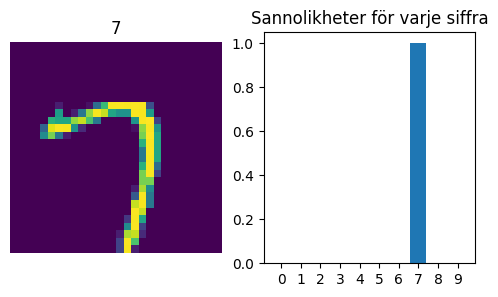

Rätt siffra: 7 Prediktion: 7 


In [134]:
for _ in range(1):
    bild, siffra = next(examples)
    ut = model_cnn(bild)
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title(ut.argmax(dim=1).item())
    plt.imshow(bild[0][0])
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Sannolikheter för varje siffra")
    plt.bar(range(10), torch.exp(ut[0]).detach().numpy())
    plt.xticks(range(10))
    plt.show()
    print(f"Rätt siffra: {siffra.item()} Prediktion: {ut.argmax(dim=1).item()} ")

tensor([1])
tensor([3])


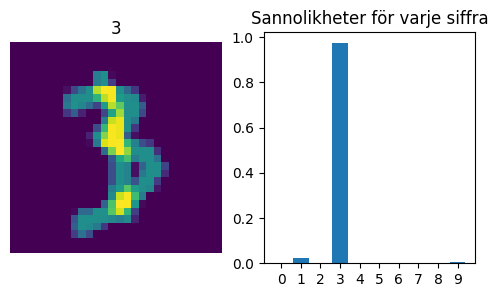

In [136]:
#Skapa en bild med två bilder
bilds = torch.zeros(1,1,28,28)
_n = 2
for _ in range(_n):
    bild, siffra = next(examples)
    bilds+=bild
    print(siffra)

    
ut = model_cnn(bilds)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title(ut.argmax(dim=1).item())
plt.imshow(bilds[0][0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Sannolikheter för varje siffra")
plt.bar(range(10), torch.exp(ut[0]).detach().numpy())
plt.xticks(range(10))
plt.show()

## Saker att tänka på/ändra för att optimera ett neuralt nätverk.

* **Dropout**
 * Dropout är en regleringsmetod som används under träning av neurala nätverk för att förhindra överanpassning.I PyTorch kan dropout-lager användas med `torch.nn.Dropout(p)`, där p är sannolikheten att en enhet slås av under träning.
* **BatchNormalization**
    * Batch normalization är en teknik som används för att normalisera indata för varje mini-batch under träning av neurala nätverk.I PyTorch kan batch normalization-lager användas med `torch.nn.BatchNorm1d`, `torch.nn.BatchNorm2d`, eller `torch.nn.BatchNorm3d`, beroende på dimensionen av datan.
* **Vikt-initialisering**
    * Viktinitialisering är processen att välja startvärden för vikterna i neurala nätverk.I PyTorch kan vikter initialiseras med standardinitialisering eller med olika initialiseringsmetoder som Xavier-initialisering (`torch.nn.init.xavier_uniform_` eller `torch.nn.init.xavier_normal_`) och He-initialisering (`torch.nn.init.kaiming_uniform_` eller `torch.nn.init.kaiming_normal_`)
* **Transfer Learning**
    * Transfer learning är en teknik där en modell som är tränad på en uppgift används som grund för att lösa en annan liknande uppgift. I PyTorch kan förtränade modeller från torchvision (till exempel ResNet, VGG, osv.) laddas och anpassas för att lösa specifika uppgifter.
* **Regularization**
    * Regularisering är processen att lägga till en extra term till förlustfunktionen för att begränsa modellens kapacitet och därigenom förhindra överanpassning. I PyTorch kan regularisering uppnås med dropout, L1-regularisering (`torch.nn.L1Loss`), L2-regularisering (`torch.nn.MSELoss`), eller med inbyggda optimerare som stöder inbyggd viktreglering.
* **Augmentering av data**
    * Dataaugmentering är processen att generera nya träningsinstanser genom att göra små slumpmässiga förändringar på befintliga datainstanser. I PyTorch kan dataaugmentering göras med bibliotek som `torchvision.transforms` genom att tillämpa olika transformationer som rotation, skalning, spegling, osv.
* **Normalisering av data**
    * Normalisering av data är processen att skala indata till ett intervall eller en viss fördelning för att underlätta inlärningen för neurala nätverk. I PyTorch kan data normaliseras genom att subtrahera medelvärdet och dividera med standardavvikelsen för att få en nollcentrerad fördelning med enhetsvarians. Detta kan göras manuellt eller med `torchvision.transforms.Normalize`.
* **Utöver alla ovan**
    * Ändra batchsize, antalet epoker, optimerar, learning rate, ta bort outliers m.m